
# TP CNN, part 3 : super-resolution

Lab led by Alasdair Newson
## Objective:

We want to implement a Convolutional Neural Network (CNN) to do image super-resolution.

## Image super-resolution:

The super-resolution problem can be summarised as follows. We have an image as an input, which is defined over a grid $\{0,1,\dots, m-1\} \times \{0,1,\dots, n-1\}$. We define a factor $\delta$, by which we upsample the image. The output of the super-resolution is an image defined on the grid $\{0,\frac{1}{\delta},\dots, m-1\} \times \{0,\frac{1}{\delta},\dots, n-1\}$.

## Model

In this part of the TP, you have complete freedom to create any model you want, as long as the input is an image, and the output is also an image of size $\delta m \times \delta n$. You will have to choose the architecture and loss which seems reasonable to you.

To help you, here is a function to upsample images in neural networks :

- ```from tensorflow.keras.layers import UpSampling2D```

Of course, you can use any upsampling layer you wish. 

## Dataset

We will be using the mnist dataset for this part. This is to ensure that you can obtain good results. The input data should be the subsampled version of the mnist images, subsampled by taking one out of every $\delta$ pixels. The output data should be the normal-resolution mnist images.

__IMPORTANT NOTES:__
- Think carefully about what the training data and labels are in this case, and create them accordingly
- We will use ```n_max=5000``` to limit the number of datapoints (as in part 1) to go faster
- We set $\delta$ to 2 in this TP, because it is not too difficult to create a network that works with this factor. If you change it, it might be more difficult to create a satisfactory network.

# Your task:
You have to load the mnist data (see the first part of the TP), create the model, train it, and evaluate and display the results.

We have created a function ```super_res_interpolate```, which carries out super-resolution using basic interpolation (bilinear or bicubic), with which you can compare your results visually and numerically.



In [ ]:

# # Load packages

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import optimizers
from scipy import interpolate
print(tf.keras.__version__)

2.7.0


This next cell is the only code you are given to carry out the TP. This function carries out a bilinear upsampling, with which you can compare your super-resolution. This function is __not__ supposed to be used by you in your network.

In [ ]:
# choice of the interpolation method
interp_method = 'linear'
# upsampling factor
delta = 2
# the maximum number of data to take from mnist (to go a bit faster)
n_max = 5000

# upsample by a factor of delta
# by definition, the new grid has a step size of 1/delta
def super_res_interpolate(imgs_in,delta,interp_method = 'linear'):
	imgs_out = tf.image.resize( tf.constant(imgs_in),\
		[delta*imgs_in.shape[1],delta*imgs_in.shape[2]], method='bilinear').numpy()
	return(imgs_out)


## Create your super-resolution network

The rest is up to you ! Import the data, format it (you can use the first part of the TP as help), create your network, train it, and compare the results with ```super_res_interpolate```.

Your network should be able to achieve about $80\%$ accuracy.

__Note__ you can obviously create as many cells as you like in your work.

## Create data demanded

In [ ]:
from keras.datasets import mnist
(X_train, Y_train_scalar), (X_test, Y_test_scalar) = mnist.load_data()

n_max = 5000
X_train = X_train[0:n_max,:,:]
X_test = X_test[0:n_max,:,:]
Y_train_scalar = Y_train_scalar[0:n_max]
Y_test_scalar = Y_test_scalar[0:n_max]

print(X_train.shape)
print(X_test.shape)

(5000, 28, 28)
(5000, 28, 28)


## Sub-sample the data

In [ ]:
# we subsample the data by retrieving the data by a step o 2 on each dimention of all the images
X_sub_train = X_train[:,0::2,0::2]
X_sub_test = X_test[:,0::2,0::2]
print(X_sub_train.shape)

Y_train = X_train
Y_test = X_test

(5000, 14, 14)


Now, let's look at some of the data :

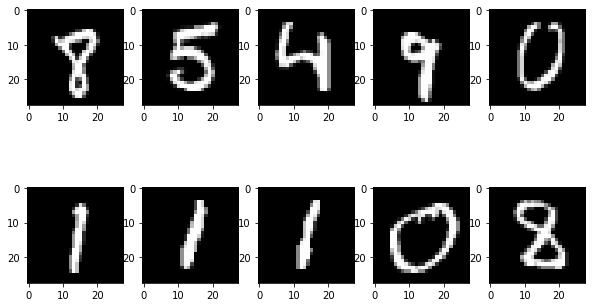

In [ ]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_train.shape[0])
    plt.imshow(X_test[rand_ind,:,:],cmap='gray')


Now sub sampled:

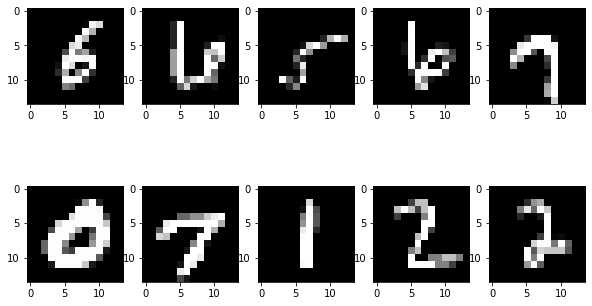

In [ ]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_train.shape[0])
    plt.imshow(X_sub_test[rand_ind,:,:],cmap='gray')


## Creating the model

In [ ]:
def get_model(upscale_factor=2):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = Input(shape=(14, 14, 1))
    x = Conv2D(64, 5, **conv_args)(inputs)
    x = Conv2D(64, 3, **conv_args)(x)
    x = Conv2D(32, 3, **conv_args)(x)
    x = Conv2D((upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return Model(inputs, outputs)

In [ ]:
model = get_model()

## Training the data

In [ ]:
# set parameters
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 40

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

history = model.fit(X_sub_train, Y_train, epochs=epochs, verbose=2)

Epoch 1/40
157/157 - 31s - loss: 812.6461 - accuracy: 0.6885 - 31s/epoch - 199ms/step
Epoch 2/40
157/157 - 1s - loss: 418.0431 - accuracy: 0.7851 - 868ms/epoch - 6ms/step
Epoch 3/40
157/157 - 1s - loss: 377.4742 - accuracy: 0.7910 - 840ms/epoch - 5ms/step
Epoch 4/40
157/157 - 1s - loss: 360.1826 - accuracy: 0.7928 - 845ms/epoch - 5ms/step
Epoch 5/40
157/157 - 1s - loss: 345.2762 - accuracy: 0.7942 - 839ms/epoch - 5ms/step
Epoch 6/40
157/157 - 1s - loss: 340.5685 - accuracy: 0.7946 - 861ms/epoch - 5ms/step
Epoch 7/40
157/157 - 1s - loss: 330.2155 - accuracy: 0.7956 - 861ms/epoch - 5ms/step
Epoch 8/40
157/157 - 1s - loss: 324.6272 - accuracy: 0.7959 - 868ms/epoch - 6ms/step
Epoch 9/40
157/157 - 1s - loss: 319.4923 - accuracy: 0.7963 - 864ms/epoch - 6ms/step
Epoch 10/40
157/157 - 1s - loss: 314.3575 - accuracy: 0.7966 - 838ms/epoch - 5ms/step
Epoch 11/40
157/157 - 1s - loss: 312.8570 - accuracy: 0.7967 - 863ms/epoch - 5ms/step
Epoch 12/40
157/157 - 1s - loss: 308.2488 - accuracy: 0.7969 -

## Eval of data


In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_sub_test, Y_test, verbose=1)
print("test loss, test acc:", results)

Evaluate on test data
157/157 [==============================] - 1s 4ms/step - loss: 300.4548 - accuracy: 0.8077
test loss, test acc: [300.454833984375, 0.8076946139335632]


## Summary of neural network

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 4)         1156      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, 28, 28, 1)        0         
 ambda)                                                          
                                                             

## Display
We can see a visual display that: 
- Our model has whites that are less solid wih a level of gradiency that is noticeable but irrelevant to the identification of the image
- The super res has a similar situation, but the numbers are less solid and the images it returns has more pixeling

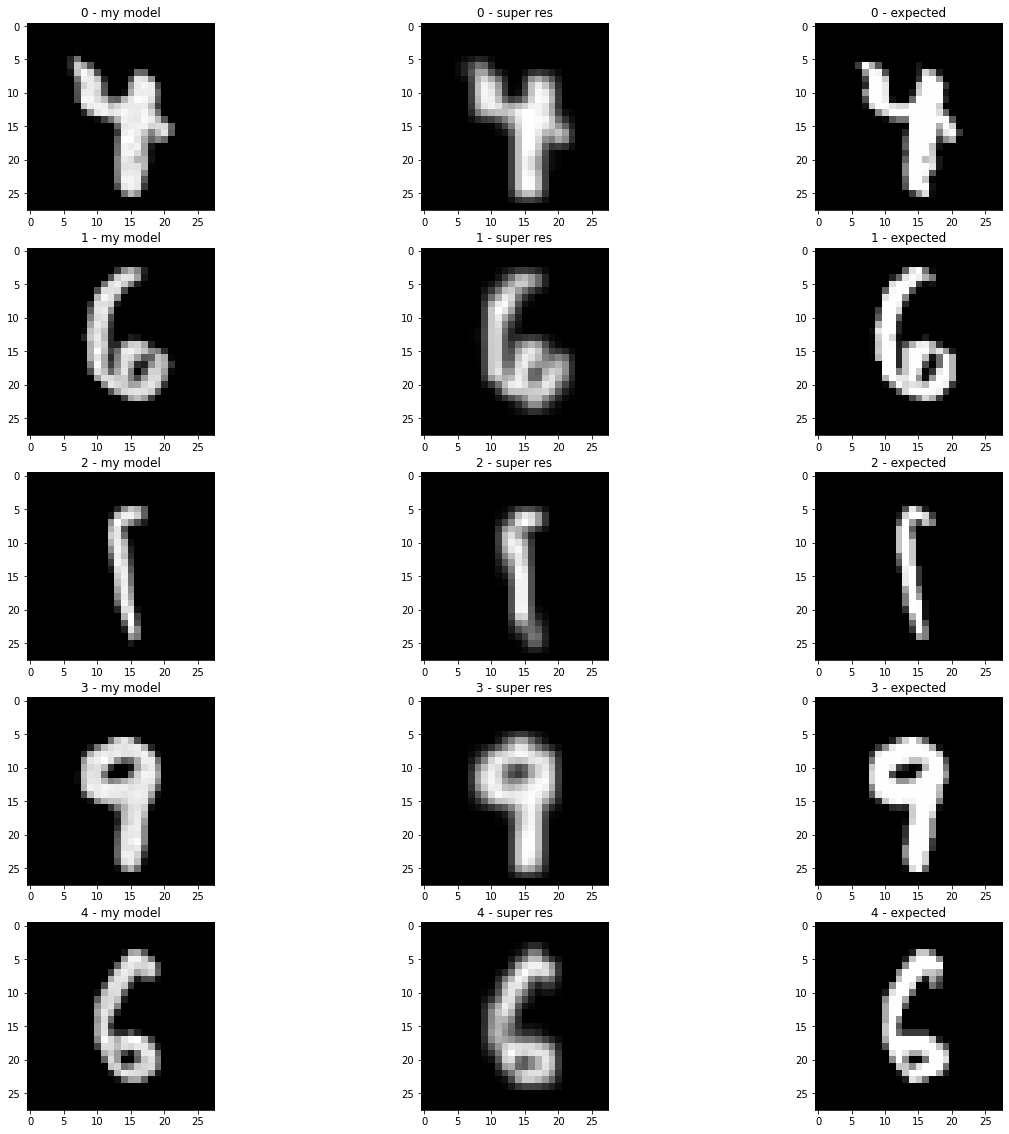

In [ ]:
import random 
idx = random.sample(range(0, n_max), 5)
my_model_out = model.predict(X_sub_test[idx])
super_res_out = super_res_interpolate(np.expand_dims(X_sub_test[idx], axis=3),delta=2)
expected_out = Y_test[idx]
labels = ["my model", "super res", "expected"]

plt.figure(figsize=(20, 20))
for i in range(0,5*3):
    plt.subplot(5, 3, i+1)
    if i%3 == 0:
        plt.imshow(my_model_out[i//3][:,:,0],cmap='gray')
    elif i%3 == 1:
        plt.imshow(super_res_out[i//3][:,:,0],cmap='gray')
    else:
        plt.imshow(expected_out[i//3],cmap='gray')
    plt.title(str(i//3)+' - '+labels[i%3])

# BONUS
Apply logistic regression to the predicted data.

In [ ]:
X_train_reconstruct  = model.predict(X_sub_train)
X_test_reconstruct=model.predict(X_sub_test)
Y_train_scalar.shape

(60000,)

In [ ]:
# Train a simple linear classifier
from sklearn.linear_model import LogisticRegression
b,m,n = X_train.shape

logreg = LogisticRegression(max_iter=3000,C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train_reconstruct[:,:,:,0].reshape(b,m*n), Y_train_scalar)

predicted_labels = logreg.predict(X_test_reconstruct[:,:,:,0].reshape(b,m*n)) 

accuracy = np.sum(Y_test_scalar == predicted_labels) / predicted_labels.size
print('Accuracy with a linear classifier: %.2f%%' % (accuracy*100))

Accuracy with a linear classifier: 83.46%
